# Linear Regression (Model Training)

In [145]:
#import required packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split # Train Test Split Package
import statsmodels.api as sm # Import statsmodels module


import matplotlib.pyplot as plt
import seaborn as sns

Note : As we are going to input data into a linear regression model it is important to remember that the dependent (target) variable must contain continuous data.

As all independent variables are numerical (no categorical data) present we do not have to perfrom any encoding of the data. If categorical data was present within the independent variables we would perform dummy encoding.

In [146]:
# Read in CSV data to Dataframe
df = pd.read_csv('AA.csv')
saved_df = df.copy(deep = True) # create copy of orginal dataframe

# Drop Multiple Columns (not required for this analysis)
df = df.drop(['Date','Adj Close'], axis=1)

# subset of data
df = df.iloc[5000:5200]
df.reset_index(inplace=True) # Reset the index to default integer index
df.head()


,index,Open,High,Low,Close,Volume
0,5000,8.110125,8.158185,7.95393,7.95393,476600
1,5001,7.953930,7.977960,7.90587,7.90587,138800
2,5002,7.905870,7.977960,7.88184,7.90587,278200
3,5003,7.905870,7.977960,7.80975,7.92990,287800
4,5004,7.929900,8.110125,7.83378,7.85781,170700


# Feature Engineering

In [147]:
# Price Change + Direction
df['closing_price_change'] = df['Close'].diff() # difference between the values in current row and previous row
df['pct_change'] = df['Close'].pct_change()
vals = [] # empty list
for value in df['closing_price_change']:
    if (value >= 0):
        vals.append(1)
    else:
        vals.append(0)           
df['price_change_direction'] = vals # Postive v Negative (Trend Direction)


# Moving Averages
df['SMA'] = df.Close.rolling(window=10).mean() # SMA -->> simple moving average (SMA)
df['CMA'] = df.iloc[:,2].expanding(min_periods=10).mean() # -->> cumaltive moving average (CMA)
df['50ema'] = df.iloc[:,2].ewm(span=50,adjust=False).mean() # -->> exponential moving average (50 day EMA) (weight on recent prices)
df['200ema'] = df.iloc[:,2].ewm(span=200,adjust=False).mean() # -->> exponential moving average (200 day EMA) (weight on recent prices)


# Moving Average Convergence Divergence (MACD)
df['short_ema'] = df.Close.ewm(span=12,adjust=False).mean() # -->> short EMA
df['long_ema'] = df.Close.ewm(span=26,adjust=False).mean() # -->> short EMA
df['macd'] = df.short_ema - df.long_ema # -->> macd line
df['signal'] = df.macd.ewm(span=9,adjust=False).mean() # -->> signal
df['macd_difference_signal'] = df.macd - df.signal
mds = [] # empty list
for value in df['macd_difference_signal']:
    if (value >= 0):
        mds.append("positive")
    else:
        mds.append("negative")           
# df['mds_direction'] = mds # Postive v Negative (Trend Direction) ---->>>> removing for LR modeling preliminary stages


# Relative Strenght Index (RSI)
delta = df['Close'].diff()
gain = (delta.where(delta>0,0)).rolling(window=14).mean() # average gains (MAs)
loss = (-delta.where(delta<0,0)).rolling(window=14).mean() # average losses (MAs)
rs = gain/loss # RS = avg_gains/avg_losses
rsi = 100 - (100/(1+rs))
df['RSI'] = rsi # rsi value
df['rsi_change'] = df.RSI.diff() # rsi_change()
#
#  RSI direction change
rsi_c = [] # empty list
for val in df['rsi_change']:
    if (val>= 0):
        rsi_c.append(1)
    else:
        rsi_c.append(0)           
df['rsi_change_direction'] = rsi_c # Postive v Negative (Trend Direction)
#
# RSI overbought v oversold flag
indicator = []
for i in range(len(df)):
    if df['RSI'][i] > 70:
        indicator.append("RSI_overbought_indicator")
    elif df['RSI'][i] < 30:
        indicator.append("RSI_oversold_indicator")
    else:
       indicator.append(np.nan)
# df['rsi_indicator'] = indicator ---->>>> removing for LR modeling preliminary stages



# (SHORT) Bollingor Bands (SMA, UpperBand + LowerBand) - 20 PERIOD
df['bollingor_band_sma'] = df['Close'].rolling(window=20).mean() # Calculate the 20-period Simple Moving Average (SMA)
df['bb_sma_std'] = df['Close'].rolling(window=20).std() # Calculate the 20-period Standard Deviation (SD)
df['bb_upper_band'] = df['bollingor_band_sma'] + 2 * df['bb_sma_std'] # Calculate the Upper Bollinger Band (UB) x2 std above
df['bb_lower_band'] = df['bollingor_band_sma'] - 2 * df['bb_sma_std'] # Calculate the Lower Bollinger Band (LB) x2 std below


df.head(100)

,index,Open,High,Low,Close,Volume,closing_price_change,pct_change,price_change_direction,SMA,...,macd,signal,macd_difference_signal,RSI,rsi_change,rsi_change_direction,bollingor_band_sma,bb_sma_std,bb_upper_band,bb_lower_band
0,5000,8.110125,8.158185,7.953930,7.953930,476600,NaN,NaN,0,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,0,NaN,NaN,NaN,NaN
1,5001,7.953930,7.977960,7.905870,7.905870,138800,-0.048060,-0.006042,0,NaN,...,-0.003834,-0.000767,-0.003067,NaN,NaN,0,NaN,NaN,NaN,NaN
2,5002,7.905870,7.977960,7.881840,7.905870,278200,0.000000,0.000000,1,NaN,...,-0.006794,-0.001972,-0.004822,NaN,NaN,0,NaN,NaN,NaN,NaN
3,5003,7.905870,7.977960,7.809750,7.929900,287800,0.024030,0.003040,1,NaN,...,-0.007119,-0.003001,-0.004117,NaN,NaN,0,NaN,NaN,NaN,NaN
4,5004,7.929900,8.110125,7.833780,7.857810,170700,-0.072090,-0.009091,0,NaN,...,-0.013043,-0.005010,-0.008033,NaN,NaN,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5095,7.377210,7.377210,7.329150,7.377210,928000,-0.132165,-0.017600,0,7.456509,...,0.062777,0.081754,-0.018977,50.943404,-6.788548,0,7.462516,0.131958,7.726432,7.198601
96,5096,7.377210,7.509375,7.353180,7.377210,546300,0.000000,0.000000,1,7.431278,...,0.051793,0.075762,-0.023969,42.857162,-8.086242,0,7.466121,0.128368,7.722857,7.209385
97,5097,7.377210,7.557435,7.377210,7.557435,505900,0.180225,0.024430,1,7.436084,...,0.056975,0.072005,-0.015030,48.000003,5.142842,1,7.481140,0.119914,7.720968,7.241311
98,5098,7.557435,7.581465,7.557435,7.557435,189300,0.000000,0.000000,1,7.454106,...,0.060385,0.069681,-0.009295,48.979603,0.979600,1,7.482341,0.120584,7.723509,7.241173


In [ ]:
df = df.dropna() # Remove rows containing ANY NaN value (model preparations -->> error will be raised with any nan values)
print(df.isnull().sum()) # check dataframe for null value count



Total NaN in each column?
index                     0
Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
closing_price_change      0
pct_change                0
price_change_direction    0
SMA                       0
CMA                       0
50ema                     0
200ema                    0
short_ema                 0
long_ema                  0
macd                      0
signal                    0
macd_difference_signal    0
RSI                       0
rsi_change                0
rsi_change_direction      0
bollingor_band_sma        0
bb_sma_std                0
bb_upper_band             0
bb_lower_band             0
dtype: int64


# Correlation Analysis


Note : It is important to differentiate between the following statistical measurements covariance and correlation.

- Covariance refers to the linear association between two variables. A positive value indicates a direct or increasing linear relationship. A negative value indicates a decreasing relationship Covariance indicates nothing about the strength of the relationship. Covariance has no upper or lower bound its scale is dependent on the two vairables in question.

- Correlation refers to the linear association between two variables similarly to covariance however correlation provides both the direction and strength of the relationship. Correlation as always between zero and one in its scale is independent of the two variables in question.



For Linear regression highly correlated independent variables can cause multicolinearity within the algorithim. It is good practice to use a scatterplot to visualize this along with the above check which can help analyse this plausible dilemma. A threshold value should be set in advance of this check and if the threshold is surpasses opt to remove one of the set correlated variables.

In contrast for linear regression it is ideal if independent variables are correlated with the dependent (target) variable.

                           index      Open      High       Low     Close  \
index                   1.000000  0.443416  0.473211  0.437474  0.457774   
Open                    0.443416  1.000000  0.983641  0.983654  0.967057   
High                    0.473211  0.983641  1.000000  0.983575  0.986020   
Low                     0.437474  0.983654  0.983575  1.000000  0.982171   
Close                   0.457774  0.967057  0.986020  0.982171  1.000000   
Volume                  0.099810  0.209532  0.226888  0.201844  0.213139   
closing_price_change    0.066393 -0.071822  0.064338  0.051068  0.168336   
pct_change              0.068932 -0.072157  0.064996  0.049410  0.167221   
price_change_direction  0.035393 -0.077448  0.015810  0.024477  0.102563   
SMA                     0.396505  0.909387  0.893515  0.895050  0.878532   
CMA                    -0.451264  0.101705  0.063792  0.089470  0.065625   
50ema                  -0.069050  0.579783  0.542714  0.561333  0.532660   
200ema      

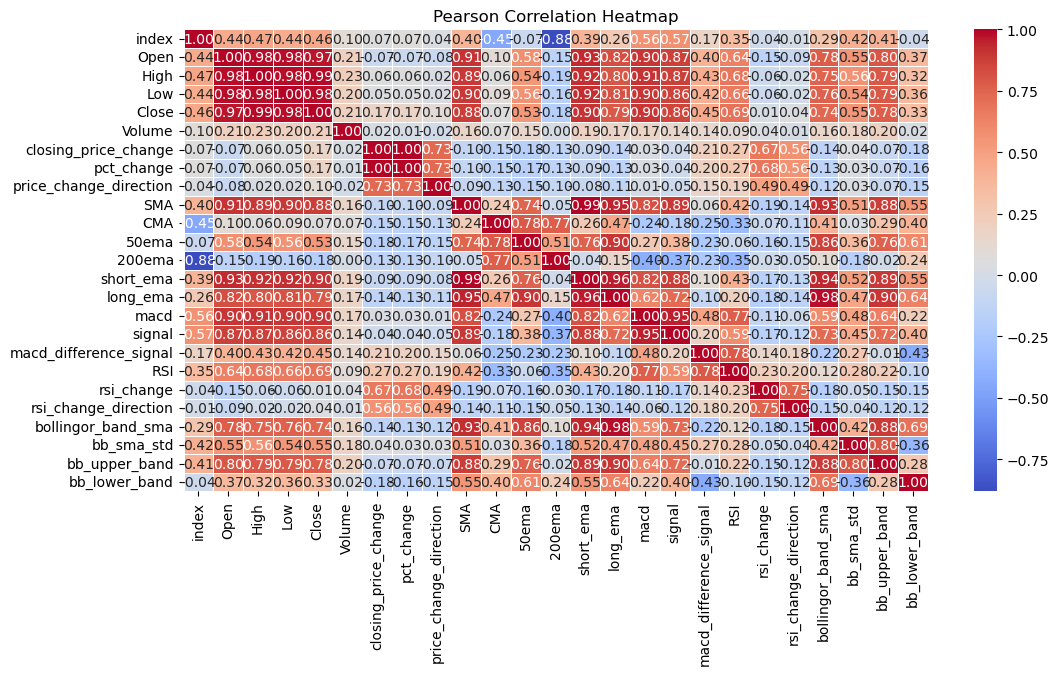

In [149]:
#Correlation check between all variables
correlation = df.corr(method='pearson')
print(correlation)

plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Pearson Correlation Heatmap')
plt.show()

# Modeling Preparations

- Splitting Data into Train Test Partitions

As the dataframe we are using for experimentation reasons is off small scale we will utilize a 70/30 train test split. The model will train on the labelled training data and test on the unseen labelled testing data.
The training data will be increased normally when the dataset is of a large scale for example ( train 80: test 20) dependent on domain and domain problem.

In [150]:
# Performing train test split on the data
train, test = train_test_split(df,test_size = 0.3,random_state=31,shuffle=False) # shuffle will maintain the order of both train & test data (time series)
X_train = train.drop(['Close'],axis=1)
y_train = train.filter(['Close']) # filter () will filter only records -->> (Linear Regression dependent traget variable)
X_test = test.drop(['Close'],axis=1)
y_test = test.filter(['Close'])


# Regression Modeling

In [151]:
#Initialize the OLS model
##Training the OLS model on segregated training data
model = sm.OLS(y_train,X_train)
#Testing the OLS model on segragated test data
results = model.fit()

In [152]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Close   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.421e+05
Date:                Thu, 10 Apr 2025   Prob (F-statistic):                   3.03e-251
Time:                        21:46:33   Log-Likelihood:                          286.04
No. Observations:                 126   AIC:                                     -532.1
Df Residuals:                     106   BIC:                                     -475.3
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [153]:
# Display Intercept
display(results.params[0])
# Display Intercept
display(results.params[1])

# Extracting result metrics
print('Parameters: ', results.params)
print('Standard errors: ', results.bse)

-0.00019400000891423887

0.3264288148054888

Parameters:  index                    -1.940000e-04
Open                      3.264288e-01
High                      6.563115e-02
Low                       1.212890e-01
Volume                   -4.953079e-09
closing_price_change     -4.873270e-01
pct_change                7.807835e+00
price_change_direction    1.205792e-03
SMA                       1.147938e-01
CMA                       2.604072e-01
50ema                    -1.000073e+00
200ema                    1.187814e-01
short_ema                 3.961068e-01
long_ema                 -2.672763e-02
macd                      4.228344e-01
signal                   -1.314071e+00
macd_difference_signal    1.736906e+00
RSI                       1.648037e-03
rsi_change               -1.068656e-03
rsi_change_direction     -1.399575e-02
bollingor_band_sma        2.519195e-01
bb_sma_std               -8.654725e-03
bb_upper_band             2.346101e-01
bb_lower_band             2.692290e-01
dtype: float64
Standard errors:  index             

In [154]:
# Create DataFrame including result parameters, standard errors and predicted values
Model_Results = pd.DataFrame ({'Model Coefficients': results.params, 'Result Standard Errors': results.bse})
display(Model_Results)

,Model Coefficients,Result Standard Errors
index,-1.940000e-04,1.678587e-04
Open,3.264288e-01,6.265485e-02
High,6.563115e-02,5.153893e-02
Low,1.212890e-01,3.858523e-02
Volume,-4.953079e-09,4.738986e-09
closing_price_change,-4.873270e-01,3.800036e-01
pct_change,7.807835e+00,2.839310e+00
price_change_direction,1.205792e-03,7.815298e-03
SMA,1.147938e-01,1.461078e-01
CMA,2.604072e-01,3.584189e-01


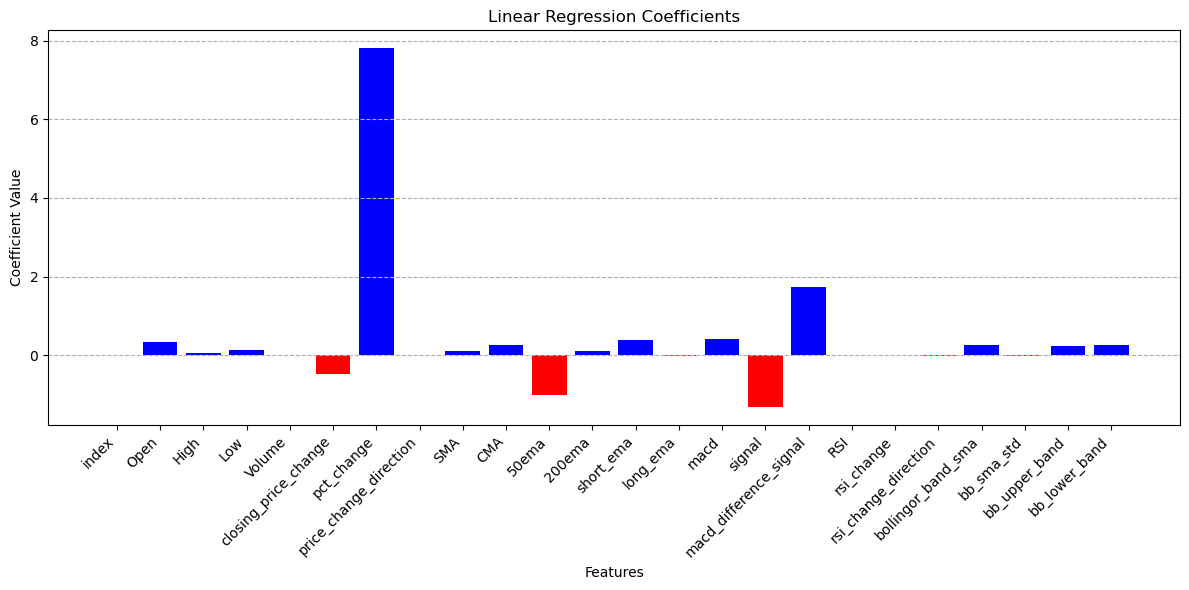

In [155]:
# Determine colors based on coefficient sign
colors = ['blue' if val > 0 else 'red' for val in Model_Results['Model Coefficients']]

# Create the bar plot with colored bars
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.bar(Model_Results.index, Model_Results['Model Coefficients'].values, color=colors)
plt.title('Linear Regression Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--')
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [156]:
# Create DataFrame including the models predicted values
model_df_results = pd.DataFrame ({'Open': X_train.Open,'High':X_train.High,
                                  'Low':X_train.Low,'Volume':X_train.Volume,
                                  'Close(dependent)':y_train.Close,
                                  'Predicted(dependent)':results.predict().tolist(),
                                  'residuals':y_train.Close - results.predict().tolist()}) # tolist() -->>

Predicted_Values = pd.DataFrame ({'Models Predicted Values': results.predict()}) # predicted values

# Calculation of Mean Squared Error (MSE) 
from sklearn.metrics import mean_squared_error  
mse = mean_squared_error(model_df_results['Close(dependent)'],model_df_results['Predicted(dependent)'])
print(mse.round(4))

model_df_results

0.0006


,Open,High,Low,Volume,Close(dependent),Predicted(dependent),residuals
19,7.629525,7.833780,7.629525,88500,7.809750,7.771377,0.038373
20,7.809750,7.833780,7.629525,308600,7.653555,7.655103,-0.001548
21,7.653555,7.677585,7.581465,463000,7.605495,7.644412,-0.038917
22,7.605495,7.605495,7.377210,122800,7.581465,7.594399,-0.012935
23,7.581465,7.605495,7.509375,306800,7.605495,7.605211,0.000284
...,...,...,...,...,...,...,...
140,7.052805,7.052805,6.776460,154800,6.932655,6.934641,-0.001986
141,6.776460,6.776460,6.704370,282600,6.776460,6.732920,0.043540
142,6.776460,6.776460,6.728400,293600,6.728400,6.746108,-0.017708
143,6.728400,6.908625,6.704370,634800,6.752430,6.775995,-0.023565


The Mean Squared Error (MSE) or Mean Squared Deviation (MSD) of an estimator measures the average of error squares i.e. the average squared difference between the estimated values and true value. It is a risk function, corresponding to the expected value of the squared error loss. It is always non – negative and values close to zero are better. The MSE is the second moment of the error (about the origin) and thus incorporates both the variance of the estimator and its bias.

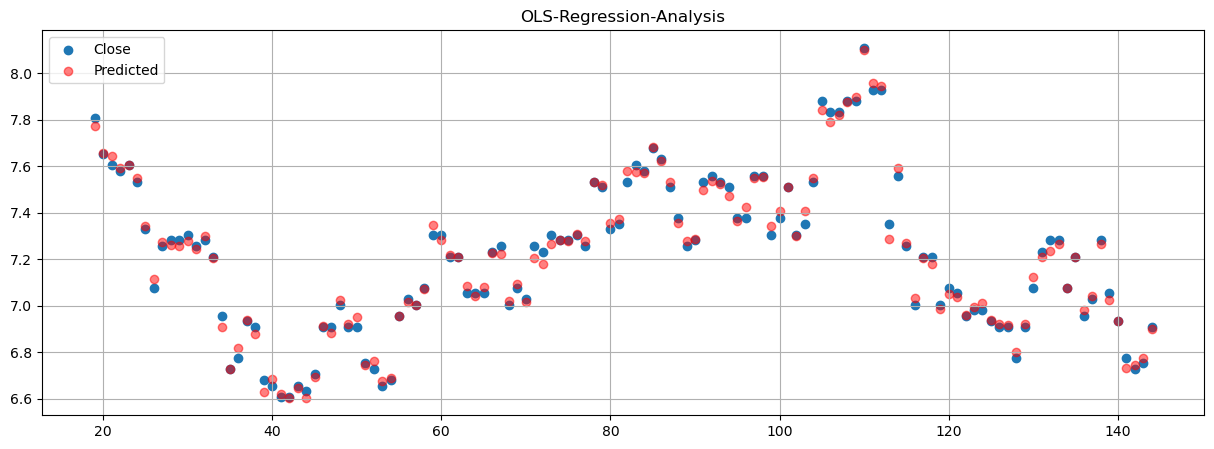

In [157]:
plt.figure(figsize=[15,5])
plt.grid(True)
plt.scatter(model_df_results.index,model_df_results['Close(dependent)'],label='Close')
plt.scatter(model_df_results.index,model_df_results['Predicted(dependent)'],label='Predicted',color='red',alpha=0.5)
plt.title('OLS-Regression-Analysis')
plt.legend(loc=2)